# Exercises: Mean Reversion on Futures - Answer Key
By Chris Fenaroli, Delaney Mackenzie, and Maxwell Margenot

## Lecture Link
https://www.quantopian.com/lectures/introduction-to-pairs-trading

https://www.quantopian.com/lectures/mean-reversion-on-futures

###IMPORTANT NOTE: 
This lecture corresponds to the Mean Reversion on Futures lecture, which is part of the Quantopian lecture series. This homework expects you to rely heavily on the code presented in the corresponding lecture. Please copy and paste regularly from that lecture when starting to work on the problems, as trying to do them from scratch will likely be too difficult.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


----

## Key Concepts

In [1]:
# Useful Functions
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [2]:
# Useful Libraries
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from quantopian.research.experimental import history, continuous_future
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

----

#Exercise 1: Testing Artificial Examples

We'll use some artificially generated series first as they are much cleaner and easier to work with. In general when learning or developing a new technique, use simulated data to provide a clean environment. Simulated data also allows you to control the level of noise and difficulty level for your model.

##a. Cointegration Test I

Determine whether the following two artificial series $A$ and $B$ are cointegrated using the `coint()` function and a reasonable confidence level.

In [3]:
A_returns = np.random.normal(0, 1, 100)
A = pd.Series(np.cumsum(A_returns), name='X') + 50

some_noise = np.random.exponential(1, 100)
 
B = A - 7 + some_noise

#Your code goes here

A and B are cointegrated
6.96867595624e-15


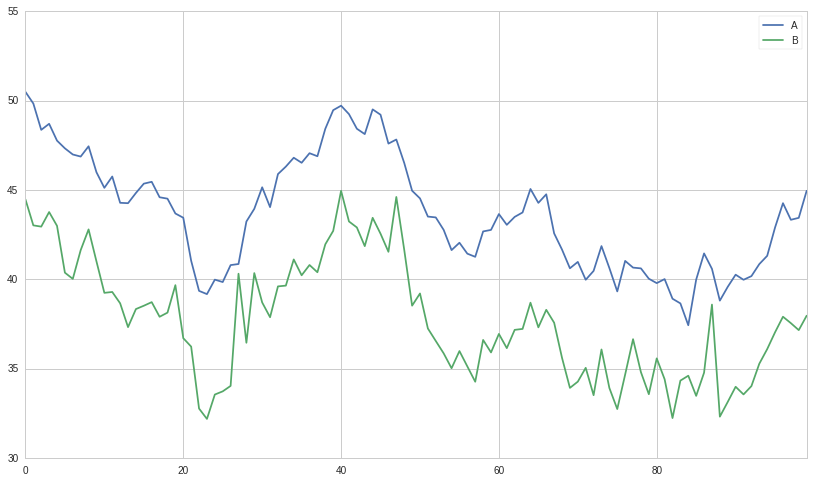

In [4]:
## answer key ##
score, pvalue, _ = coint(A,B)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("A and B are cointegrated")
    print pvalue
else:
    print ("A and B are not cointegrated")
    print pvalue
    
A.name = "A"
B.name = "B"
pd.concat([A, B], axis=1).plot();

##b. Cointegration Test II

Determine whether the following two artificial series $C$ and $D$ are cointegrated using the `coint()` function and a reasonable confidence level.

In [5]:
C_returns = np.random.normal(1, 1, 100) 
C = pd.Series(np.cumsum(C_returns), name='X') + 100

D_returns = np.random.normal(2, 1, 100)
D = pd.Series(np.cumsum(D_returns), name='X') + 100

#Your code goes here

C and D are not cointegrated
0.487261538359


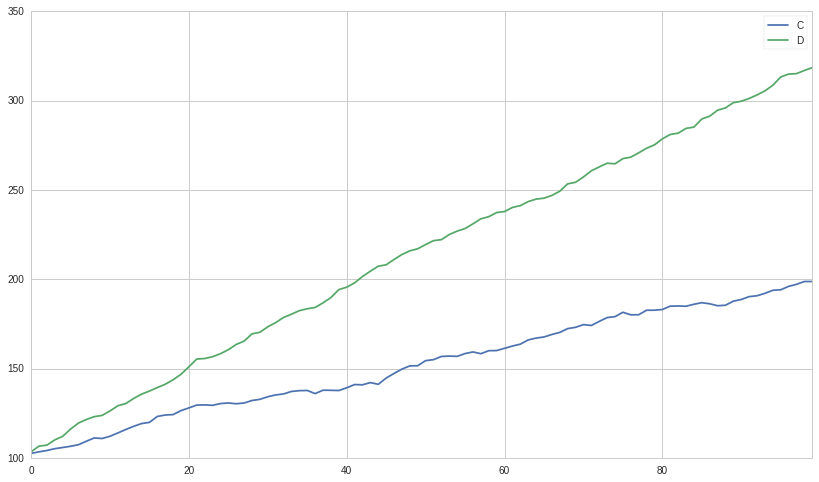

In [6]:
## answer key ##
score, pvalue, _ = coint(C,D)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("C and D are cointegrated")
    print pvalue
else:
    print ("C and D are not cointegrated")
    print pvalue

C.name = "C"
D.name = "D"
pd.concat([C, D], axis=1).plot();

----

#Exercise 2: Testing Real Examples

##a. Real Cointegration Test I

Determine whether the following two assets `CN` and `SB` were cointegrated during 2015 using the `coint()` function and a reasonable confidence level.

In [7]:
cn = continuous_future('CN', offset = 0, roll = 'calendar', adjustment = 'mul')
sb = continuous_future('SB', offset = 0, roll = 'calendar', adjustment = 'mul')

cn_price = history(cn, 'price', '2015-01-01', '2016-01-01', 'daily')
sb_price = history(sb, 'price', '2015-01-01', '2016-01-01', 'daily')

#Your code goes here
#print history.__doc__

CN and SB are not cointegrated
0.605183628116


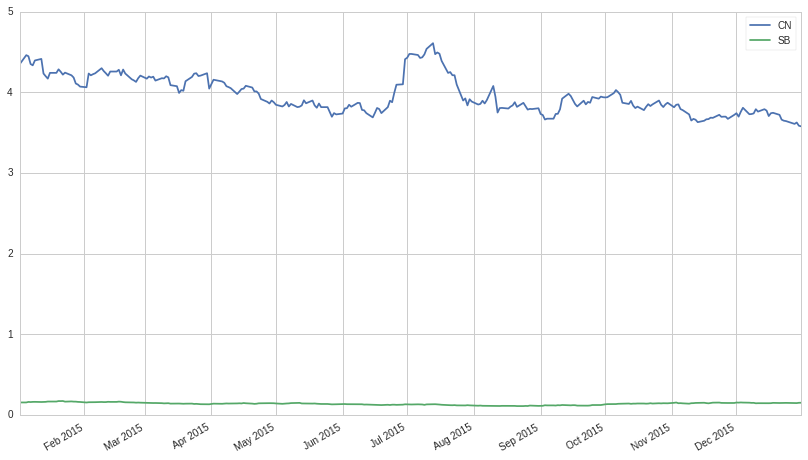

In [8]:
## answer key ##
score, pvalue, _ = coint(cn_price, sb_price)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("CN and SB are cointegrated")
    print pvalue
else:
    print ("CN and SB are not cointegrated")
    print pvalue

cn_price.name = "CN"
sb_price.name = "SB"
pd.concat([cn_price, sb_price], axis=1).plot();

##b. Real Cointegration Test II

Determine whether the following two underlyings `CL` and `HO` were cointegrated during 2015 using the `coint()` function and a reasonable confidence level.

In [9]:
cl = continuous_future('CL', offset = 0, roll = 'calendar', adjustment = 'mul')
ho = continuous_future('HO', offset = 0, roll = 'calendar', adjustment = 'mul')

cl_price = history(cl, 'price', '2015-01-01', '2016-01-01', 'daily')
ho_price = history(ho, 'price', '2015-01-01', '2016-01-01', 'daily')

#Your code goes here

CL and HO are cointegrated
0.0470273399855


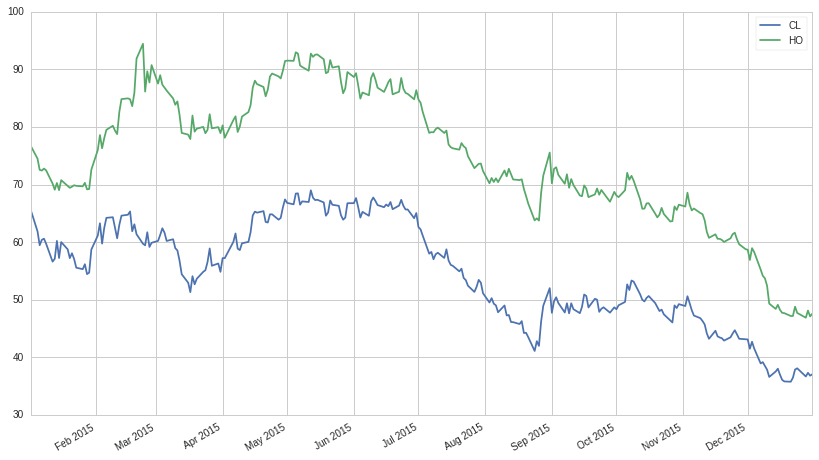

In [10]:
## answer key ##
confidence_level = 0.05

score, pvalue, _ = coint(cl_price, ho_price)

if pvalue < confidence_level:
    print ("CL and HO are cointegrated")
    print pvalue
else:
    print ("CL and HO are not cointegrated")
    print pvalue

cl_price.name = 'CL'
ho_price.name = 'HO'
pd.concat([cl_price, ho_price.multiply(42)], axis=1).plot();

----

#Exercise 3: Out of Sample Validation

##a. Calculating the Spread

Using pricing data from 2015, construct a linear regression to find a coefficient for the linear combination of `CL` and `HO` that makes their spread stationary.

30.3502596624
p-value for in-sample stationarity:  0.0124116865765


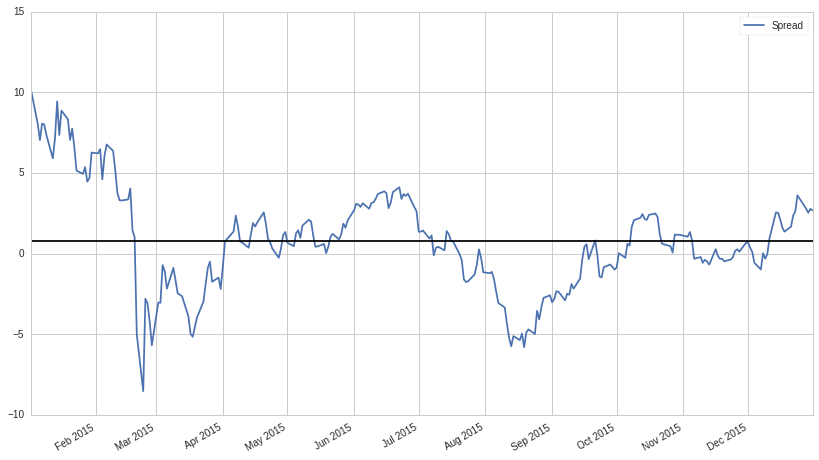

In [11]:
## answer key ##
results = sm.OLS(cl_price, sm.add_constant(ho_price)).fit()
b = results.params['HO']

print b
spread = cl_price - b * ho_price
print "p-value for in-sample stationarity: ", adfuller(spread)[1]
# The p-value is less than 0.05 so we conclude that this spread calculation is stationary in sample
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

##b. Testing the Coefficient

Use your coefficient from part a to plot the weighted spread using prices from the first half of 2016, and check whether the result is still stationary.

In [12]:
cl_out = get_pricing(cl, fields='price', 
                        start_date='2016-01-01', end_date='2016-07-01')
ho_out = get_pricing(ho, fields='price', 
                        start_date='2016-01-01', end_date='2016-07-01')

#Your code goes here

p-value for spread stationarity:  0.00434011120184


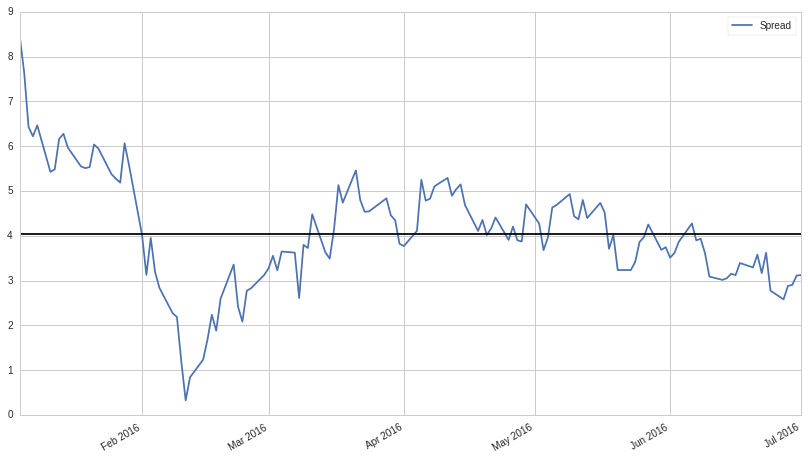

In [13]:
## answer key ##

spread = cl_out - b * ho_out
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

print "p-value for spread stationarity: ", adfuller(spread)[1]
# Our p-value is less than 0.05 so we conclude that this calculation of
# the spread is stationary out of sample

----

#Extra Credit Exercise: Hurst Exponent

This exercise is more difficult and we will not provide initial structure.

The Hurst exponent is a statistic between 0 and 1 that provides information about how much a time series is trending or mean reverting. We want our spread time series to be mean reverting, so we can use the Hurst exponent to monitor whether our pair is going out of cointegration. Effectively as a means of process control to know when our pair is no longer good to trade.

Please find either an existing Python library that computes, or compute yourself, the Hurst exponent. Then plot it over time for the spread on the above pair of stocks.

These links may be helpful:

* https://en.wikipedia.org/wiki/Hurst_exponent
* https://www.quantopian.com/posts/pair-trade-with-cointegration-and-mean-reversion-tests

In [14]:
# No solution provided for extra credit exercises.

---

Congratulations on completing the Mean Reversion on Futures exercises!

As you learn more about writing trading models and the Quantopian platform, enter the daily [Quantopian Contest](https://www.quantopian.com/contest). Your strategy will be evaluated for a cash prize every day.

Start by going through the [Writing a Contest Algorithm](https://www.quantopian.com/tutorials/contest) tutorial.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solic
itation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*